# READ README.MD FOR OBSERVATIONS ON WHAT WAS TRIED

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras import Sequential,models
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau,CSVLogger,EarlyStopping
import os
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,RMSprop
import cv2
from sklearn import metrics,preprocessing
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import pickle

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

main_dict = {
    'filenames': [],
    'labels' :[],
    'data': []
}

for filename in ['/media/yodenharsh/Crucial P3/Research/cifar-10-batches-py/data_batch_' + str(x) for x in range(1,6)]:
    batch = unpickle(filename)
    main_dict['filenames'].extend(batch[b'filenames'])
    main_dict['data'].extend(batch[b'data'])
    main_dict['labels'].extend(batch[b'labels'])

In [3]:
# Check keys

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

unpickle('/media/yodenharsh/Crucial P3/Research/cifar-10-batches-py/data_batch_1').keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [28]:
for i in main_dict.items():
    print(type(i))

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


Train test split

Splitting test into validation again

In [7]:
X_train, X_test, y_train, y_test = train_test_split(main_dict['data'],main_dict['labels'],test_size=0.2,random_state=1337)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, test_size=0.5,random_state=1337)

Making model

In [42]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_48 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_49 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

Adding callbacks

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
csv_logger = CSVLogger(filename="./epochs.csv")
early_stopping = EarlyStopping(patience=10,mode="min",monitor="val_loss")


Organizing splits to fit into model

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print(X_test.shape)
print(y_test.shape)

(5000, 32, 32, 3)
(5000, 10)


Training

In [45]:
history = model.fit(X_train,y_train,
                    epochs=60,
                    batch_size=64,
                    validation_data=(X_val,y_val),use_multiprocessing=True,callbacks=[reduce_lr,csv_logger,early_stopping],workers=2)

Epoch 1/60


2023-11-05 12:47:36.694503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 12s 15ms/step - loss: 3.0319 - accuracy: 0.3347 - val_loss: 1.9944 - val_accuracy: 0.3936 - lr: 0.0100
Epoch 2/60
625/625 [==============================] - 9s 14ms/step - loss: 1.8779 - accuracy: 0.4401 - val_loss: 2.5572 - val_accuracy: 0.2402 - lr: 0.0100
Epoch 3/60
625/625 [==============================] - 8s 12ms/step - loss: 1.8202 - accuracy: 0.4599 - val_loss: 2.1384 - val_accuracy: 0.3852 - lr: 0.0100
Epoch 4/60
625/625 [==============================] - 8s 13ms/step - loss: 1.7956 - accuracy: 0.4696 - val_loss: 1.7118 - val_accuracy: 0.5034 - lr: 0.0100
Epoch 5/60
625/625 [==============================] - 9s 14ms/step - loss: 1.7833 - accuracy: 0.4696 - val_loss: 1.8306 - val_accuracy: 0.4568 - lr: 0.0100
Epoch 6/60
625/625 [==============================] - 8s 13ms/step - loss: 1.7562 - accuracy: 0.4752 - val_loss: 2.1008 - val_accuracy: 0.4046 - lr: 0.0100
Epoch 7/60
625/625 [==============================] - 8s 13ms/step - loss:

In [46]:
print("Accuracy = {:2f} %".format(model.evaluate(x=X_test,y=y_test)[1] * 100))

157/157 [==============================] - 1s 3ms/step - loss: 0.9933 - accuracy: 0.6792
Accuracy = 67.919999 %


Plotting loss and accuracy curves

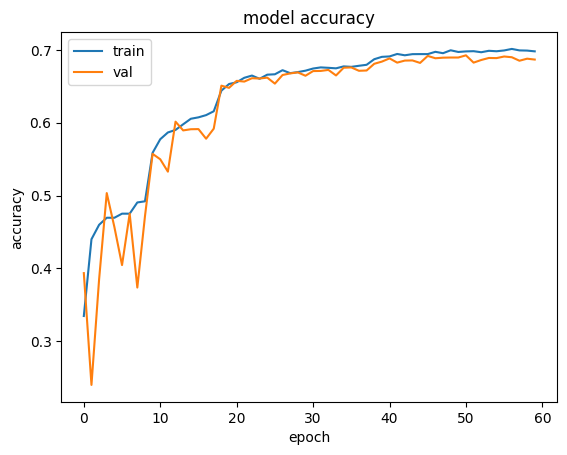

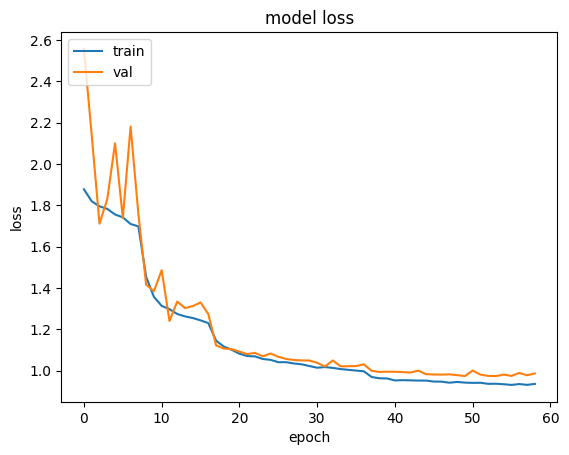

In [47]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Getting y_pred for predictions

In [61]:
y_pred = model.predict(X_test)
np.argmax(y_pred > 0.5,axis=1)


157/157 [==============================] - 0s 2ms/step


array([8, 8, 3, ..., 3, 0, 8])

Generating metrics

              precision    recall  f1-score   support

           0       0.26      0.80      0.39       474
           1       0.86      0.75      0.80       487
           2       0.75      0.33      0.46       503
           3       0.60      0.22      0.32       490
           4       0.68      0.62      0.65       477
           5       0.66      0.53      0.59       497
           6       0.74      0.74      0.74       496
           7       0.83      0.63      0.71       531
           8       0.86      0.79      0.82       524
           9       0.78      0.76      0.77       521

    accuracy                           0.62      5000
   macro avg       0.70      0.62      0.63      5000
weighted avg       0.71      0.62      0.63      5000



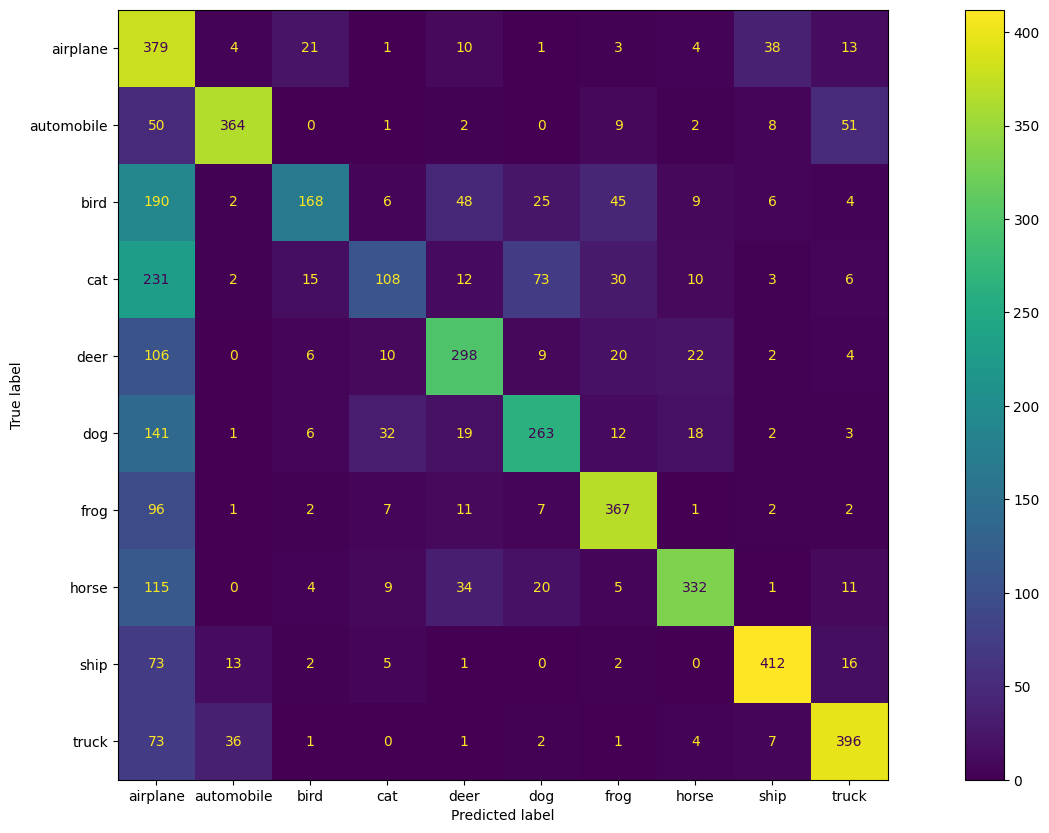

In [73]:
print(metrics.classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)))

cm = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)),
                                    display_labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
  
fig, ax = plt.subplots(figsize=(20,10))
cm.plot(ax=ax)

plt.show()

Saving model

In [74]:
model.save('model.keras')# Define the path to your "Moderate demented" images

## Custom dataset

Augmenting images

In [9]:
def augment_images(target_dir,augmented_dir):


# Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
    rescale=128./255,                
    brightness_range=[0.5, 1.5],  
    zoom_range=[0.8, 1.2],        
    fill_mode='nearest',          
    horizontal_flip=True,
              
)

# List all images in the "Moderate demented" directory
    image_files = os.listdir(target_dir)

# Set the target number of augmented images (e.g., 700)
    target_count = 30

# Loop until the target count is reached
    generated_count = 0
    while generated_count < target_count:
    # Randomly select an image from the original dataset
        image_file = np.random.choice(image_files)
        image_path = os.path.join(target_dir, image_file)

    
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

    
        aug_iter = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)
        augmented_images = [next(aug_iter)[0].astype(np.uint8) for _ in range(5)]  # Create 5 augmented images per original

    
        for i, aug_image in enumerate(augmented_images):
            aug_filename = f'augmented_{generated_count + i}.jpg'
            aug_image_path = os.path.join(augmented_dir, aug_filename)
            cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))

    
        generated_count += len(augmented_images)

    print(f'Generated {generated_count} augmented images.')

for dirpath,_,filenames in os.walk('/media/yodenharsh/Crucial P3/Research/Custom-object-detection-dataset/'):
    if(not dirpath == '/media/yodenharsh/Crucial P3/Research/Custom-object-detection-dataset/'):
        augment_images(dirpath,dirpath)

Generated 30 augmented images.
Generated 30 augmented images.
Generated 30 augmented images.
Generated 30 augmented images.
Generated 30 augmented images.
Generated 30 augmented images.


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Generated 30 augmented images.


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Generated 30 augmented images.
Generated 30 augmented images.
Generated 30 augmented images.


Load dataset

In [10]:
from PIL import Image
import os
import numpy as np

# Directory containing your image folders
base_dir = "/media/yodenharsh/Crucial P3/Research/Custom-object-detection-dataset"

# Function to load and resize an image
def load_and_resize_image(image_path, target_size=(32, 32)):
    image = Image.open(image_path)
    image = image.convert("RGB")  # Ensure images have 3 color channels (RGB)
    image = image.resize(target_size)
    image_array = np.array(image)
    return image_array

# Lists to store the resized image arrays and corresponding encoded labels
image_list = []
label_list = []
label_to_index = {}  # Dictionary to map labels to encoded numbers
index = 0

# Loop through the folders and images
for folder_name in sorted(os.listdir(base_dir)):  # Sort folder names alphabetically
    folder_path = os.path.join(base_dir, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_array = load_and_resize_image(image_path)
                image_list.append(image_array)
                label_list.append(folder_name)
                if folder_name not in label_to_index:
                    label_to_index[folder_name] = index
                    index += 1

# Now, image_list contains the resized image arrays, and label_list contains the corresponding encoded labels

image_list = np.array(image_list)
label_list =  np.array(label_list)

print(image_list.shape)
le = preprocessing.LabelEncoder()

# fit and transform the numpy array
label_list = le.fit_transform(label_list)
label_list.shape

/home/yodenharsh/miniforge3/envs/ml_stuff/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


(335, 32, 32, 3)


(335,)

In [12]:
X = image_list
y = to_categorical(label_list)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=255)
X_test,X_val,y_test,y_val =  train_test_split(X_test,y_test,test_size=0.5,random_state=255)

Loading the model

In [13]:
model = models.load_model("./model.keras")

2023-11-07 10:41:14.166435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 10:41:15.499996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-07 10:41:15.500333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Training the model on these images

In [14]:
history = model.fit(X_train,y_train,
                    epochs=200,
                    batch_size=1024,
                    use_multiprocessing=True,validation_data=(X_val,y_val))

Epoch 1/200


2023-11-07 10:41:19.870731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-07 10:41:20.360965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2023-11-07 10:41:22.470294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-07 10:41:22.702032: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7ffc5ac120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-07 10:41:22.702081: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-11-07 10:41:22.707913: I tensorflow/compiler/mlir/tensorflow/

1/1 [==============================] - 17s 17s/step - loss: 3.3097 - accuracy: 0.1795 - val_loss: 3.2197 - val_accuracy: 0.1373
Epoch 2/200
1/1 [==============================] - 0s 229ms/step - loss: 3.3566 - accuracy: 0.1966 - val_loss: 3.2060 - val_accuracy: 0.1569
Epoch 3/200
1/1 [==============================] - 0s 224ms/step - loss: 3.3329 - accuracy: 0.1880 - val_loss: 3.1963 - val_accuracy: 0.1765
Epoch 4/200
1/1 [==============================] - 0s 227ms/step - loss: 3.3398 - accuracy: 0.2009 - val_loss: 3.1876 - val_accuracy: 0.1765
Epoch 5/200
1/1 [==============================] - 0s 223ms/step - loss: 3.2728 - accuracy: 0.2308 - val_loss: 3.1774 - val_accuracy: 0.1765
Epoch 6/200
1/1 [==============================] - 0s 219ms/step - loss: 3.2870 - accuracy: 0.2051 - val_loss: 3.1656 - val_accuracy: 0.1765
Epoch 7/200
1/1 [==============================] - 0s 223ms/step - loss: 3.2478 - accuracy: 0.1880 - val_loss: 3.1531 - val_accuracy: 0.1765
Epoch 8/200
1/1 [=========

Metrics

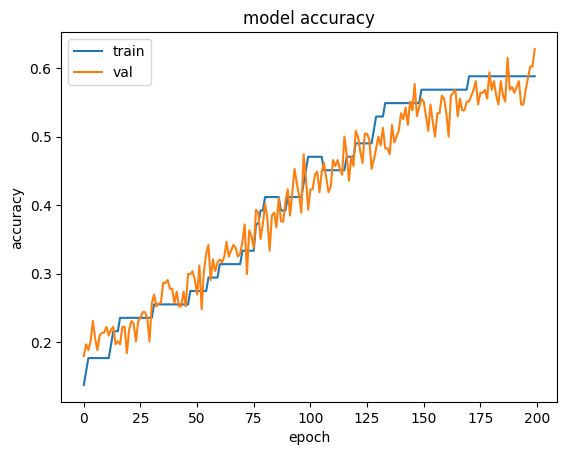

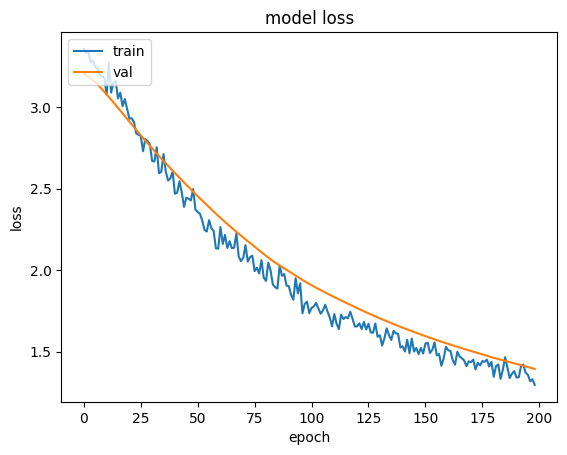

In [16]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.12      1.00      0.22         4
           1       0.00      0.00      0.00         5
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.67      0.50      0.57         4
           7       0.33      0.25      0.29         4
           8       1.00      0.57      0.73         7
           9       1.00      0.67      0.80         6

    accuracy                           0.32        50
   macro avg       0.41      0.33      0.31        50
weighted avg       0.41      0.32      0.31        50



/home/yodenharsh/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yodenharsh/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yodenharsh/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


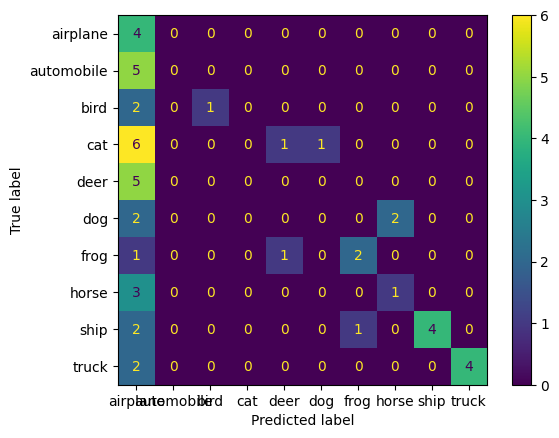

In [15]:
model.evaluate(X_test,y_test)

y_pred = model.predict(X_test)

print(metrics.classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)))

cm = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)),
                                    display_labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
  
cm.plot()

plt.show()